In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing Libraries
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils import plot_model, model_to_dot
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization

In [ ]:
keras.backend.set_image_data_format('channels_last')

In [ ]:
def evaluate(predicted_outcome, expected_outcome):
    from sklearn import metrics
    f1_score = metrics.f1_score(expected_outcome, predicted_outcome, average='weighted')
    balanced_accuracy_score = metrics.balanced_accuracy_score(expected_outcome, predicted_outcome)
    return f1_score, balanced_accuracy_score

In [ ]:
# Data Preprocessing
def load_dataset_with_processing(input_train_test_fn, num_classes=10):
    data = np.load(input_train_test_fn)
    X_train, X_test, y_train, y_test = data['X_train'], data['X_test'], data['y_train'], data['y_test']

    # split validation set
    from sklearn.model_selection import train_test_split
    X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

    X_train = np.array(X_train, dtype="float") / 255.0
    X_train = X_train.reshape(X_train.shape[0], 28, 28,1 )
    print(X_train.shape)

    X_vali = np.array(X_vali, dtype="float") / 255.0
    X_vali = X_vali.reshape(X_vali.shape[0], 28, 28,1 )
    print(X_vali.shape)

    X_test = np.array(X_test, dtype="float") / 255.0
    X_test = X_test.reshape(X_test.shape[0], 28, 28,1 )
    print(X_test.shape)

    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_vali = keras.utils.to_categorical(y_vali, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return X_train, y_train, X_vali, y_vali, X_test, y_test

In [ ]:
# Creating a data generator for real-time data augmentation
def myGenerator(X_train, y_train, batch_size):
    total_size = X_train.shape[0]

    while True:
        permutation = list(np.random.permutation(total_size))
        for i in range(total_size//batch_size):
            index = permutation[i * batch_size : (i + 1) * batch_size]
            X_batch = X_train[index]
            y_batch = y_train[index]

            yield X_batch, y_batch

In [ ]:
# Define ALEXNET Model
def build_model(input_shape, num_classes):
   model = Sequential([
        # Layer 1
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'), # Adjusted stride and added padding

        # Layer 2
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'), # Adjusted stride and added padding

        # Layer 3
        Conv2D(384, (3, 3), padding='same', activation='relu'),

        # Layer 4
        Conv2D(384, (3, 3), padding='same', activation='relu'),

        # Layer 5
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'), # Adjusted stride and added padding

        Flatten(),

        # Layer 6
        Dense(4096, activation='relu'),
        Dropout(0.5),

        # Layer 7
        Dense(4096, activation='relu'),
        Dropout(0.5),
    ])

   for layer in model.layers:
        layer.trainable = False  # freeze the previous layers

   X = model.output
   # softmax classifier
   predictions = Dense(10, activation='softmax')(X)
   old_model = Model(inputs=model.input, outputs=predictions)

   # load weights
   old_model.load_weights('/content/drive/MyDrive/pretrained_mnist/alexnet.h5')

   X = model.output
   # softmax classifier
   predictions = Dense(num_classes, activation='softmax')(X)
   new_model = Model(inputs=model.input, outputs=predictions)
   new_model.summary()

   return new_model

input_shape = (28, 28, 1)
num_classes = 100
model = build_model(input_shape, num_classes)

Model: "model_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_195_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_195 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_117 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_117 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_196 (Conv2D)         (None, 3, 3, 256)         614656    
                                                          

In [ ]:
def train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs):
    import os
    if os.path.exists(checkpoint_dir) is False:
        os.makedirs(checkpoint_dir)

    model = build_model(input_shape, num_classes)

    checkpoint = ModelCheckpoint(checkpoint_dir + 'best_alexnet.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    datagen = myGenerator(X_train, y_train, batch_size)

    history = model.fit(datagen,
                        steps_per_epoch = len(X_train) // batch_size,
                        epochs=epochs,
                        callbacks=[es, checkpoint],
                        verbose=2,
                        validation_data=(X_vali, y_vali))

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    return model

In [ ]:
def test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights):
    model = build_model(input_shape, num_classes)

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    # load weights
    model.load_weights(pretrained_weights)

    score = model.evaluate(X_test, y_test, verbose=0)

    testPredict = model.predict(X_test)
    y_test_tmp = np.argmax(y_test, axis=1)
    y_pred_tmp = np.argmax(testPredict, axis=1)
    f1_score, balanced_accuracy_score = evaluate(y_pred_tmp, y_test_tmp)

    return score[1], f1_score, balanced_accuracy_score  # return accuracies

Training ALEXNET on individual datasets


(5280, 28, 28, 1)
(1320, 28, 28, 1)
(1000, 28, 28, 1)
Model: "model_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_200_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_200 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_120 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_120 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_201 (Conv2D)         (None, 3, 3, 256)         614656    
    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 2s - loss: 0.9321 - accuracy: 0.8028 - val_loss: 0.6004 - val_accuracy: 0.8477 - 2s/epoch - 48ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.84773
41/41 - 0s - loss: 0.6292 - accuracy: 0.8436 - val_loss: 0.5601 - val_accuracy: 0.8409 - 427ms/epoch - 10ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.84773 to 0.85606, saving model to ./ADRIS_ALEXNET_MNIST_MIX/best_alexnet.hdf5
41/41 - 1s - loss: 0.6622 - accuracy: 0.8300 - val_loss: 0.5373 - val_accuracy: 0.8561 - 679ms/epoch - 17ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.85606 to 0.85985, saving model to ./ADRIS_ALEXNET_MNIST_MIX/best_alexnet.hdf5
41/41 - 1s - loss: 0.6321 - accuracy: 0.8428 - val_loss: 0.5892 - val_accuracy: 0.8598 - 829ms/epoch - 20ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.85985 to 0.86439, saving model to ./ADRIS_ALEXNET_MNIST_MIX/best_alexnet.hdf5
41/41 - 1s - loss: 0.6195 - accuracy: 0.8453 - val_loss: 0.5169 - val_accuracy: 0.8644 - 673ms/epoch - 1

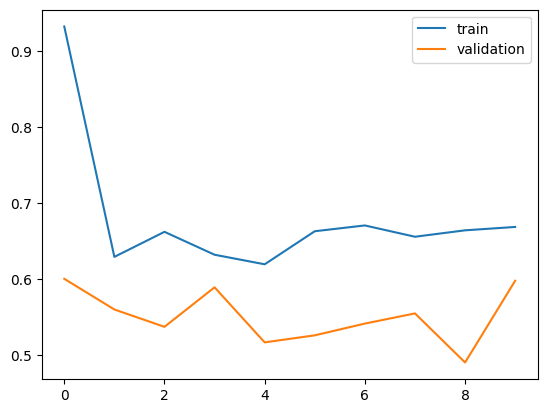

In [ ]:
# Training on ARDIS Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ADRIS_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/ARDIS_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on ADRIS test data
pretrained_weights = '/content/ADRIS_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_205_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_205 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_123 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_123 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_206 (Conv2D)         (None, 3, 3, 256)         614656    
                                                          

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_210_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_210 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_126 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_126 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_211 (Conv2D)         (None, 3, 3, 256)         614656    
      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 2s - loss: 2.4332 - accuracy: 0.3734 - val_loss: 1.6750 - val_accuracy: 0.4896 - 2s/epoch - 102ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.48958
15/15 - 0s - loss: 1.9028 - accuracy: 0.4802 - val_loss: 1.7771 - val_accuracy: 0.4479 - 216ms/epoch - 14ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.48958
15/15 - 0s - loss: 1.8309 - accuracy: 0.4714 - val_loss: 1.5415 - val_accuracy: 0.4875 - 193ms/epoch - 13ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.48958 to 0.53542, saving model to ./ARABIC_ALEXNET_MNIST_MIX/best_alexnet.hdf5
15/15 - 0s - loss: 1.9130 - accuracy: 0.4901 - val_loss: 1.7971 - val_accuracy: 0.5354 - 460ms/epoch - 31ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.53542
15/15 - 0s - loss: 2.0320 - accuracy: 0.5057 - val_loss: 1.5501 - val_accuracy: 0.4938 - 173ms/epoch - 12ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.53542
15/15 - 0s - loss: 1.7953 - accuracy: 0.5115 - val_loss:

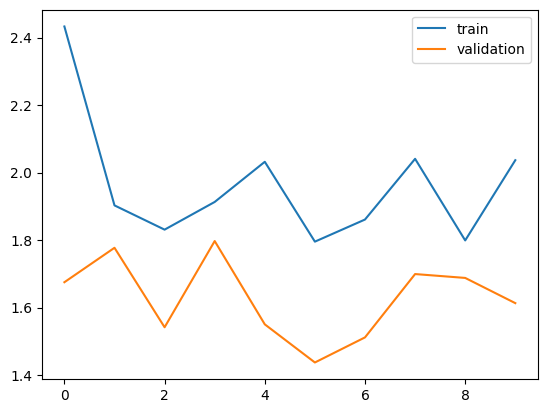

In [ ]:
# Training on CMATTERDB 3.3.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ARABIC_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Arabic_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTER 3.3.1 test data
pretrained_weights = '/content/ARABIC_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_215_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_215 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_129 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_129 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_216 (Conv2D)         (None, 3, 3, 256)         614656    
                                                          

(12638, 28, 28, 1)
(3160, 28, 28, 1)
(3950, 28, 28, 1)
Model: "model_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_220_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_220 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_132 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_132 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_221 (Conv2D)         (None, 3, 3, 256)         614656    
   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


98/98 - 3s - loss: 2.0441 - accuracy: 0.4865 - val_loss: 1.7025 - val_accuracy: 0.5370 - 3s/epoch - 26ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.53703
98/98 - 1s - loss: 1.9323 - accuracy: 0.5120 - val_loss: 2.2896 - val_accuracy: 0.5161 - 875ms/epoch - 9ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.53703 to 0.55696, saving model to ./BANGLALEKHA_ALEXNET_MNIST_MIX/best_alexnet.hdf5
98/98 - 1s - loss: 2.1232 - accuracy: 0.5204 - val_loss: 1.7261 - val_accuracy: 0.5570 - 1s/epoch - 15ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.55696 to 0.56297, saving model to ./BANGLALEKHA_ALEXNET_MNIST_MIX/best_alexnet.hdf5
98/98 - 1s - loss: 2.2607 - accuracy: 0.5155 - val_loss: 1.7475 - val_accuracy: 0.5630 - 1s/epoch - 12ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.56297 to 0.56930, saving model to ./BANGLALEKHA_ALEXNET_MNIST_MIX/best_alexnet.hdf5
98/98 - 1s - loss: 2.2337 - accuracy: 0.5139 - val_loss: 1.7133 - val_accuracy: 0.5693 - 1s/e

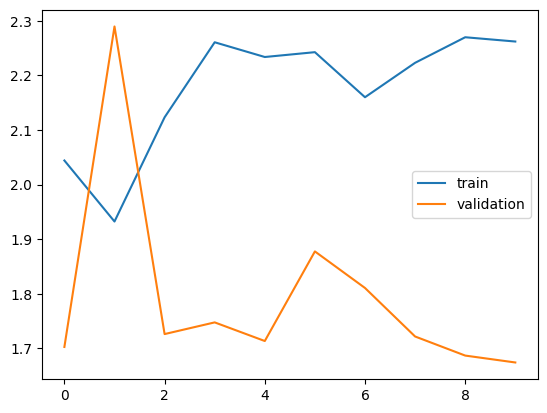

In [ ]:
# Training on BanglaLekha Isolated Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './BANGLALEKHA_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/BanglaLekha_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on BanglaLekha Isolated test data
pretrained_weights = '/content/BANGLALEKHA_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_225_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_225 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_135 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_135 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_226 (Conv2D)         (None, 3, 3, 256)         614656    
                                                          

(3840, 28, 28, 1)
(960, 28, 28, 1)
(1200, 28, 28, 1)
Model: "model_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_230_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_230 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_138 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_138 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_231 (Conv2D)         (None, 3, 3, 256)         614656    
     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 - 2s - loss: 1.9680 - accuracy: 0.4503 - val_loss: 1.5846 - val_accuracy: 0.4969 - 2s/epoch - 55ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.49687 to 0.52083, saving model to ./BANGLA_ALEXNET_MNIST_MIX/best_alexnet.hdf5
30/30 - 1s - loss: 1.7665 - accuracy: 0.5023 - val_loss: 1.4734 - val_accuracy: 0.5208 - 638ms/epoch - 21ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.52083 to 0.52917, saving model to ./BANGLA_ALEXNET_MNIST_MIX/best_alexnet.hdf5
30/30 - 1s - loss: 1.6332 - accuracy: 0.5047 - val_loss: 1.4716 - val_accuracy: 0.5292 - 559ms/epoch - 19ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.52917
30/30 - 0s - loss: 1.8030 - accuracy: 0.5073 - val_loss: 1.6134 - val_accuracy: 0.5156 - 339ms/epoch - 11ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.52917
30/30 - 0s - loss: 1.7692 - accuracy: 0.5120 - val_loss: 1.7632 - val_accuracy: 0.5292 - 332ms/epoch - 11ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from

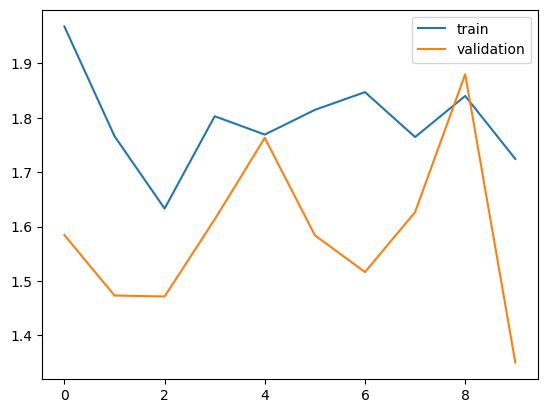

In [ ]:
# Training on CMATTERDB 3.1.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './BANGLA_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Bangla_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.1.1 test data
pretrained_weights = '/content/BANGLA_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_235_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_235 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_141 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_141 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_236 (Conv2D)         (None, 3, 3, 256)         614656    
                                                          

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_240_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_240 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_144 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_144 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_241 (Conv2D)         (None, 3, 3, 256)         614656    
      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 2s - loss: 2.1571 - accuracy: 0.4708 - val_loss: 1.6406 - val_accuracy: 0.5667 - 2s/epoch - 112ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.56667 to 0.58750, saving model to ./DEVANAGARI_ALEXNET_MNIST_MIX/best_alexnet.hdf5
15/15 - 1s - loss: 1.7063 - accuracy: 0.5521 - val_loss: 1.6102 - val_accuracy: 0.5875 - 685ms/epoch - 46ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.58750
15/15 - 0s - loss: 1.6457 - accuracy: 0.5708 - val_loss: 1.3443 - val_accuracy: 0.5500 - 316ms/epoch - 21ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.58750 to 0.60833, saving model to ./DEVANAGARI_ALEXNET_MNIST_MIX/best_alexnet.hdf5
15/15 - 1s - loss: 1.6204 - accuracy: 0.5667 - val_loss: 1.2712 - val_accuracy: 0.6083 - 771ms/epoch - 51ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.60833
15/15 - 0s - loss: 1.6157 - accuracy: 0.5792 - val_loss: 1.5195 - val_accuracy: 0.5938 - 232ms/epoch - 15ms/step
Epoch 6/10

Epoch 6: val_accuracy did not imp

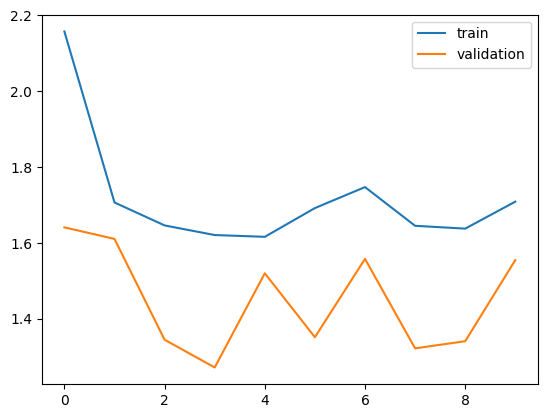

In [ ]:
# Training on CMATTERDB 3.2.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './DEVANAGARI_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Devanagari_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.2.1 test data
pretrained_weights = '/content/DEVANAGARI_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_245_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_245 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_147 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_147 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_246 (Conv2D)         (None, 3, 3, 256)         614656    
                                                          

(192000, 28, 28, 1)
(48000, 28, 28, 1)
(40000, 28, 28, 1)
Model: "model_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_260_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_260 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_156 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_156 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_261 (Conv2D)         (None, 3, 3, 256)         614656    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 - 20s - loss: 0.2051 - accuracy: 0.9686 - val_loss: 0.1389 - val_accuracy: 0.9774 - 20s/epoch - 13ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.97740
1500/1500 - 13s - loss: 0.2230 - accuracy: 0.9689 - val_loss: 0.1569 - val_accuracy: 0.9770 - 13s/epoch - 9ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.97740
1500/1500 - 13s - loss: 0.2265 - accuracy: 0.9686 - val_loss: 0.1765 - val_accuracy: 0.9764 - 13s/epoch - 9ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.97740
1500/1500 - 14s - loss: 0.2364 - accuracy: 0.9685 - val_loss: 0.1741 - val_accuracy: 0.9762 - 14s/epoch - 9ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.97740
1500/1500 - 14s - loss: 0.2371 - accuracy: 0.9689 - val_loss: 0.1793 - val_accuracy: 0.9743 - 14s/epoch - 9ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.97740
1500/1500 - 13s - loss: 0.2415 - accuracy: 0.9689 - val_loss: 0.1745 - val_accuracy: 0.9735 - 13s/epoch - 9ms

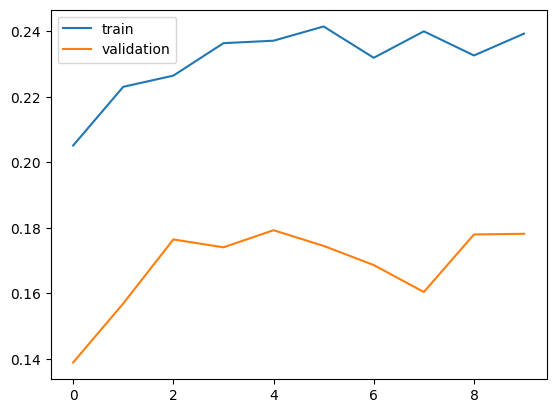

In [ ]:
# Training on EMNIST Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './EMNIST_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/EMNIST_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on EMNIST test data
pretrained_weights = '/content/EMNIST_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_104"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_265_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_265 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_159 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_159 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_266 (Conv2D)         (None, 3, 3, 256)         614656    
                                                         

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(20000, 28, 28, 1)
Model: "model_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_270_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_270 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_162 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_162 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_271 (Conv2D)         (None, 3, 3, 256)         614656    


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 - 5s - loss: 1.5074 - accuracy: 0.5841 - val_loss: 1.1886 - val_accuracy: 0.6605 - 5s/epoch - 14ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.66050
375/375 - 3s - loss: 1.5496 - accuracy: 0.6059 - val_loss: 1.1737 - val_accuracy: 0.6524 - 3s/epoch - 9ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.66050 to 0.66342, saving model to ./FARSI_ALEXNET_MNIST_MIX/best_alexnet.hdf5
375/375 - 3s - loss: 1.5760 - accuracy: 0.6056 - val_loss: 1.1955 - val_accuracy: 0.6634 - 3s/epoch - 9ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.66342
375/375 - 3s - loss: 1.5723 - accuracy: 0.6067 - val_loss: 1.0702 - val_accuracy: 0.6576 - 3s/epoch - 9ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.66342
375/375 - 5s - loss: 1.6460 - accuracy: 0.6102 - val_loss: 1.2096 - val_accuracy: 0.6495 - 5s/epoch - 13ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.66342 to 0.67992, saving model to ./FARSI_ALEXNET_MNIST_MIX/best_alexnet.hdf

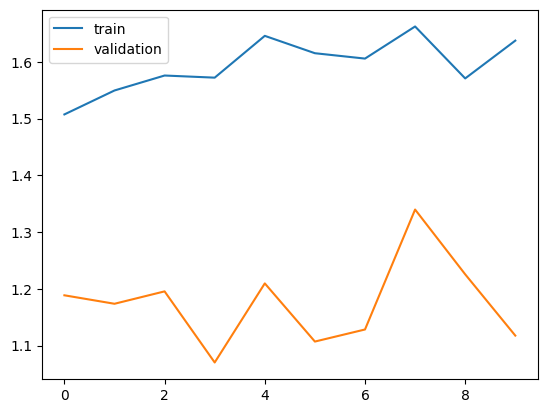

In [ ]:
# Training on FARSI Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './FARSI_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Farsi_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on FARSI test data
pretrained_weights = '/content/FARSI_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_108"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_275_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_275 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_165 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_165 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_276 (Conv2D)         (None, 3, 3, 256)         614656    
                                                         

(15513, 28, 28, 1)
(3879, 28, 28, 1)
(4000, 28, 28, 1)
Model: "model_110"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_280_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_280 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_168 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_168 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_281 (Conv2D)         (None, 3, 3, 256)         614656    
  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 - 3s - loss: 3.0655 - accuracy: 0.4429 - val_loss: 1.7471 - val_accuracy: 0.5223 - 3s/epoch - 23ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.52230 to 0.53184, saving model to ./ISIBANGLA_ALEXNET_MNIST_MIX/best_alexnet.hdf5
121/121 - 2s - loss: 3.3088 - accuracy: 0.4529 - val_loss: 1.9633 - val_accuracy: 0.5318 - 2s/epoch - 14ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.53184
121/121 - 1s - loss: 3.4963 - accuracy: 0.4671 - val_loss: 2.5510 - val_accuracy: 0.5089 - 1s/epoch - 9ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.53184
121/121 - 1s - loss: 3.4649 - accuracy: 0.4697 - val_loss: 2.5218 - val_accuracy: 0.5275 - 1s/epoch - 10ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.53184
121/121 - 1s - loss: 3.4790 - accuracy: 0.4624 - val_loss: 2.2912 - val_accuracy: 0.5241 - 1s/epoch - 12ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.53184
121/121 - 1s - loss: 3.5383 - accuracy: 0.4682 - val_loss

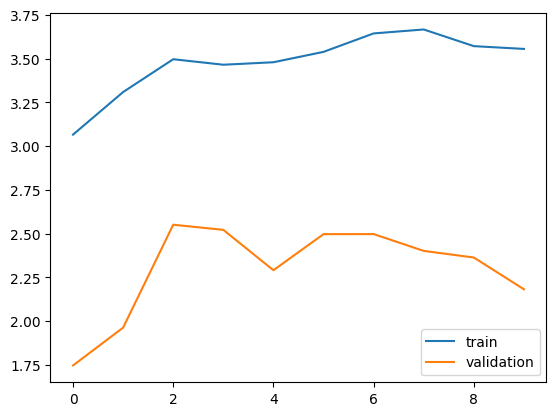

In [ ]:
# Training on ISI BANGLA Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './ISIBANGLA_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/ISI_Bangla_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on ISI BANGLA test data
pretrained_weights = '/content/ISIBANGLA_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_285_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_285 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_171 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_171 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_286 (Conv2D)         (None, 3, 3, 256)         614656    
                                                         

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(20240, 28, 28, 1)
Model: "model_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_290_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_290 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_174 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_174 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_291 (Conv2D)         (None, 3, 3, 256)         614656    


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 - 6s - loss: 1.0867 - accuracy: 0.6528 - val_loss: 0.7656 - val_accuracy: 0.7376 - 6s/epoch - 15ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.73758
375/375 - 3s - loss: 1.0578 - accuracy: 0.6656 - val_loss: 0.8260 - val_accuracy: 0.7164 - 3s/epoch - 9ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.73758
375/375 - 3s - loss: 1.0620 - accuracy: 0.6722 - val_loss: 0.8438 - val_accuracy: 0.7287 - 3s/epoch - 9ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.73758
375/375 - 5s - loss: 1.0918 - accuracy: 0.6719 - val_loss: 0.8608 - val_accuracy: 0.7163 - 5s/epoch - 13ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.73758 to 0.74250, saving model to ./KANNADA_ALEXNET_MNIST_MIX/best_alexnet.hdf5
375/375 - 4s - loss: 1.0764 - accuracy: 0.6724 - val_loss: 0.7861 - val_accuracy: 0.7425 - 4s/epoch - 10ms/step
Epoch 6/10

Epoch 6: val_accuracy improved from 0.74250 to 0.74925, saving model to ./KANNADA_ALEXNET_MNIST_MIX/best_alexne

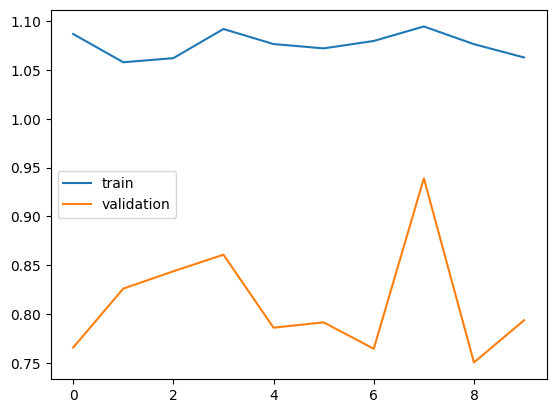

In [ ]:
# Training on Kannada Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './KANNADA_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Kannada_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on kannada test data
pretrained_weights = '/content/KANNADA_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_295_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_295 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_177 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_177 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_296 (Conv2D)         (None, 3, 3, 256)         614656    
                                                         

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
Model: "model_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_300_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_300 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_180 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_180 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_301 (Conv2D)         (None, 3, 3, 256)         614656    


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 - 5s - loss: 0.8773 - accuracy: 0.7462 - val_loss: 0.7009 - val_accuracy: 0.7952 - 5s/epoch - 15ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.79517 to 0.80342, saving model to ./MADBASE_ALEXNET_MNIST_MIX/best_alexnet.hdf5
375/375 - 4s - loss: 0.8453 - accuracy: 0.7578 - val_loss: 0.6513 - val_accuracy: 0.8034 - 4s/epoch - 11ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.80342 to 0.80367, saving model to ./MADBASE_ALEXNET_MNIST_MIX/best_alexnet.hdf5
375/375 - 5s - loss: 0.8571 - accuracy: 0.7602 - val_loss: 0.6647 - val_accuracy: 0.8037 - 5s/epoch - 14ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.80367 to 0.82267, saving model to ./MADBASE_ALEXNET_MNIST_MIX/best_alexnet.hdf5
375/375 - 4s - loss: 0.8507 - accuracy: 0.7647 - val_loss: 0.6154 - val_accuracy: 0.8227 - 4s/epoch - 11ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.82267
375/375 - 3s - loss: 0.8481 - accuracy: 0.7656 - val_loss: 0.6731 - val_accuracy: 0.8017 - 3s/epoch

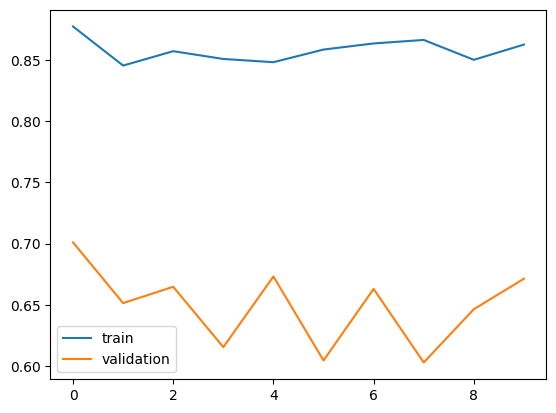

In [ ]:
# Training on MADBASE Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './MADBASE_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/MADBase_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on MADBASE test data
pretrained_weights = '/content/MADBASE_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_310_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_310 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_186 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_186 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_311 (Conv2D)         (None, 3, 3, 256)         614656    
                                                         

(1920, 28, 28, 1)
(480, 28, 28, 1)
(600, 28, 28, 1)
Model: "model_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_315_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_315 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_189 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_189 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_316 (Conv2D)         (None, 3, 3, 256)         614656    
     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 - 2s - loss: 2.5132 - accuracy: 0.3193 - val_loss: 1.8053 - val_accuracy: 0.4250 - 2s/epoch - 110ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.42500 to 0.46875, saving model to ./TELUGU_ALEXNET_MNIST_MIX/best_alexnet.hdf5
15/15 - 2s - loss: 1.7803 - accuracy: 0.4229 - val_loss: 1.7862 - val_accuracy: 0.4688 - 2s/epoch - 156ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.46875
15/15 - 0s - loss: 1.8368 - accuracy: 0.4229 - val_loss: 1.6821 - val_accuracy: 0.4208 - 234ms/epoch - 16ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.46875 to 0.48542, saving model to ./TELUGU_ALEXNET_MNIST_MIX/best_alexnet.hdf5
15/15 - 1s - loss: 1.7259 - accuracy: 0.4536 - val_loss: 1.7219 - val_accuracy: 0.4854 - 707ms/epoch - 47ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.48542
15/15 - 0s - loss: 1.7924 - accuracy: 0.4625 - val_loss: 1.5836 - val_accuracy: 0.4604 - 191ms/epoch - 13ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 

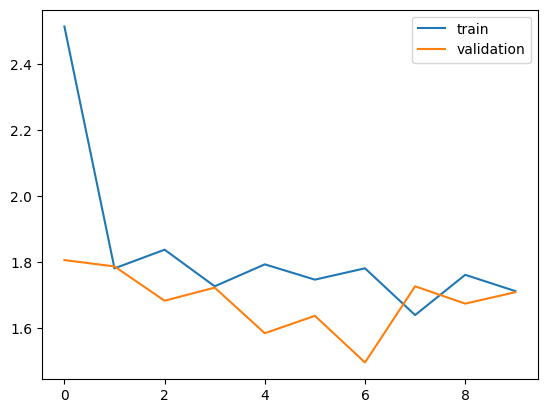

In [ ]:
# Training on CMATTERDB 3.4.1 Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './TELUGU_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Telugu_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on CMATTERDB 3.4.1 test data
pretrained_weights = '/content/TELUGU_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_320_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_320 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_192 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_192 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_321 (Conv2D)         (None, 3, 3, 256)         614656    
                                                         

(11371, 28, 28, 1)
(2843, 28, 28, 1)
(3554, 28, 28, 1)
Model: "model_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_325_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_325 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_195 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_195 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_326 (Conv2D)         (None, 3, 3, 256)         614656    
  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 - 3s - loss: 1.5026 - accuracy: 0.5547 - val_loss: 1.2188 - val_accuracy: 0.6180 - 3s/epoch - 35ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.61801 to 0.62364, saving model to ./TIBETAN_ALEXNET_MNIST_MIX/best_alexnet.hdf5
88/88 - 2s - loss: 1.3343 - accuracy: 0.5846 - val_loss: 1.2381 - val_accuracy: 0.6236 - 2s/epoch - 28ms/step
Epoch 3/10

Epoch 3: val_accuracy did not improve from 0.62364
88/88 - 1s - loss: 1.4011 - accuracy: 0.5837 - val_loss: 1.2638 - val_accuracy: 0.6229 - 811ms/epoch - 9ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.62364 to 0.63630, saving model to ./TIBETAN_ALEXNET_MNIST_MIX/best_alexnet.hdf5
88/88 - 1s - loss: 1.4444 - accuracy: 0.5794 - val_loss: 1.1281 - val_accuracy: 0.6363 - 1s/epoch - 13ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.63630 to 0.64685, saving model to ./TIBETAN_ALEXNET_MNIST_MIX/best_alexnet.hdf5
88/88 - 3s - loss: 1.4021 - accuracy: 0.5890 - val_loss: 1.3579 - val_accuracy: 0.6469 - 3s/epoch - 34ms/

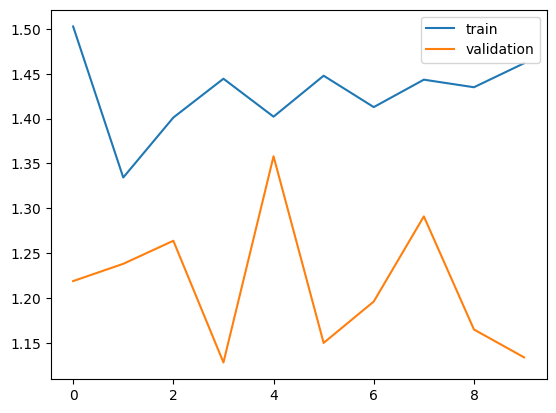

In [ ]:
# Training on Tibetan Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './TIBETAN_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Tibetan_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on TIBETAN test data
pretrained_weights = '/content/TIBETAN_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_330_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_330 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_198 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_198 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_331 (Conv2D)         (None, 3, 3, 256)         614656    
                                                         

(5284, 28, 28, 1)
(1322, 28, 28, 1)
(1414, 28, 28, 1)
Model: "model_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_335_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_335 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_201 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_201 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_336 (Conv2D)         (None, 3, 3, 256)         614656    
   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 - 2s - loss: 2.0719 - accuracy: 0.4261 - val_loss: 1.5217 - val_accuracy: 0.5348 - 2s/epoch - 53ms/step
Epoch 2/10

Epoch 2: val_accuracy did not improve from 0.53480
41/41 - 1s - loss: 1.7623 - accuracy: 0.4878 - val_loss: 1.4966 - val_accuracy: 0.5197 - 642ms/epoch - 16ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.53480 to 0.58321, saving model to ./URDU_ALEXNET_MNIST_MIX/best_alexnet.hdf5
41/41 - 4s - loss: 1.7662 - accuracy: 0.4977 - val_loss: 1.5508 - val_accuracy: 0.5832 - 4s/epoch - 110ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.58321
41/41 - 1s - loss: 1.8132 - accuracy: 0.5133 - val_loss: 1.5517 - val_accuracy: 0.5545 - 513ms/epoch - 13ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.58321
41/41 - 0s - loss: 1.8145 - accuracy: 0.5069 - val_loss: 1.6407 - val_accuracy: 0.5340 - 406ms/epoch - 10ms/step
Epoch 6/10

Epoch 6: val_accuracy did not improve from 0.58321
41/41 - 1s - loss: 1.8407 - accuracy: 0.5095 - val_loss: 1.52

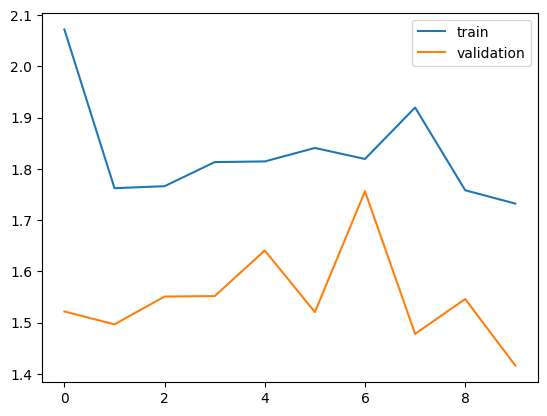

In [ ]:
# Training on URDU Dataset
img_rows, img_cols = 28 , 28
input_shape = (img_rows, img_cols, 1)
num_classes = 100
loss = 'categorical_crossentropy'
optimizer = Adam(learning_rate=0.01, clipnorm=0.001)
metrics = ['accuracy']
batch_size = 128
epochs = 10

checkpoint_dir = './URDU_ALEXNET_MNIST_MIX/'
input_train_test_fn = '/content/drive/MyDrive/mnist_mix_all/Urdu_train_test.npz'

# load data
X_train, y_train, X_vali, y_vali, X_test, y_test = load_dataset_with_processing(input_train_test_fn, num_classes=100)

train_fn(X_train, y_train, X_vali, y_vali, input_shape, num_classes, loss, optimizer, metrics, checkpoint_dir, batch_size, epochs)

In [ ]:
# Testing the saved model on URDU test data
pretrained_weights = '/content/URDU_ALEXNET_MNIST_MIX/best_alexnet.hdf5'
accuracies = test_fn(X_test, y_test, input_shape, num_classes, loss, optimizer, metrics, pretrained_weights)
print('Accuracy: ', accuracies[0])
print('Weighted F1: ', accuracies[1])
print('Balanced Accuracy: ', accuracies[2])

Model: "model_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_345_input (InputLay  [(None, 28, 28, 1)]       0         
 er)                                                             
                                                                 
 conv2d_345 (Conv2D)         (None, 5, 5, 96)          11712     
                                                                 
 batch_normalization_207 (B  (None, 5, 5, 96)          384       
 atchNormalization)                                              
                                                                 
 max_pooling2d_207 (MaxPool  (None, 3, 3, 96)          0         
 ing2D)                                                          
                                                                 
 conv2d_346 (Conv2D)         (None, 3, 3, 256)         614656    
                                                         